# 1. Import libraries and dataset

In [1]:
!pip install -q medmnist
!pip install -q xgboost scikit-learn matplotlib seaborn opencv-python albumentations scikit-image mahotas scipy imbalanced-learn umap-learn tensorflow pillow tqdm
!mkdir class_task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 64.8 MB/s eta 0:00:00


In [2]:
import medmnist
from medmnist import INFO, Evaluator, PathMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import imagesize
from collections import defaultdict
import hashlib
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
from collections import Counter
import shutil
import csv
from PIL import Image

In [3]:
!python -m medmnist save --flag=pathmnist --folder=/content/class_task/ --postfix=png --download=True --size=128

Saving pathmnist train...
100% 4.26G/4.26G [16:42<00:00, 4.25MB/s]
Saving train set to /content/class_task/pathmnist_128, csv_path=/content/class_task/pathmnist_128.csv...
100% 89996/89996 [12:19<00:00, 121.65it/s]
Saving pathmnist val...
Saving val set to /content/class_task/pathmnist_128, csv_path=/content/class_task/pathmnist_128.csv...
100% 10004/10004 [01:28<00:00, 113.52it/s]
Saving pathmnist test...
Saving test set to /content/class_task/pathmnist_128, csv_path=/content/class_task/pathmnist_128.csv...
100% 7180/7180 [01:07<00:00, 106.47it/s]


In [3]:
import pprint
pathmnist_info = INFO['pathmnist']
pprint.pprint(pathmnist_info)

{'MD5': 'a8b06965200029087d5bd730944a56c1',
 'MD5_128': 'ac42d08fb904d92c244187169d1fd1d9',
 'MD5_224': '2c51a510bcdc9cf8ddb2af93af1eadec',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'description': 'The PathMNIST is based on a prior study for predicting '
                'survival from colorectal cancer histology slides, providing a '
                'dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image '
                'patches from hematoxylin & eosin stained histological images, '
                'and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches '
                'from a different clinical center. The dataset is comprised of '
                '9 types of tissues, resulting in a multi-class classification '
                'task. We resize the source images of 3×224×224 into 3×28×28, '
                'and split NCT-CRC-HE-100K into training and validation set '
                'with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test '
                'set.

In [4]:
# I will use my Google Drive as a persistent cache
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Upload the dataset to the drive
import tarfile
with tarfile.open('/content/class_task.tar.gz', 'w:gz') as tar:
    tar.add('/content/class_task', arcname='class_task')

!mv /content/class_task.tar.gz /content/drive/MyDrive/aml_project/

In [5]:
# Import the dataset from the drive
!cp /content/drive/MyDrive/aml_project/class_task.tar.gz /content/
!tar -xzf /content/class_task.tar.gz -C /content/

# 2. Loading and processing data


Class distribution in the full dataset:
adipose                  : 11745 samples
background               : 11413 samples
debris                   : 11851 samples
lymphocytes              : 12191 samples
mucus                    : 9931 samples
muscle                   : 14128 samples
mucosa                   : 9504 samples
cas                      : 10867 samples
adenocarcinoma           : 15550 samples


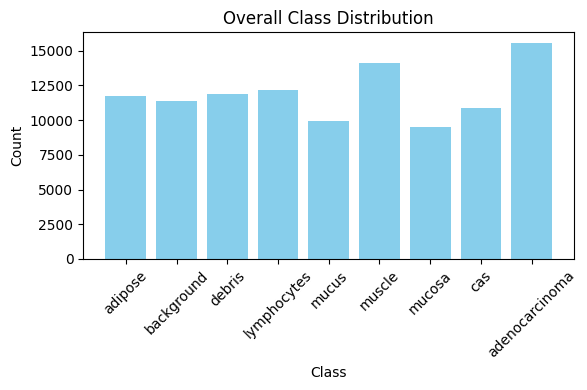


Class distribution in train set:
adipose                  : 9366 samples
background               : 9509 samples
debris                   : 10360 samples
lymphocytes              : 10401 samples
mucus                    : 8006 samples
muscle                   : 12182 samples
mucosa                   : 7886 samples
cas                      : 9401 samples
adenocarcinoma           : 12885 samples


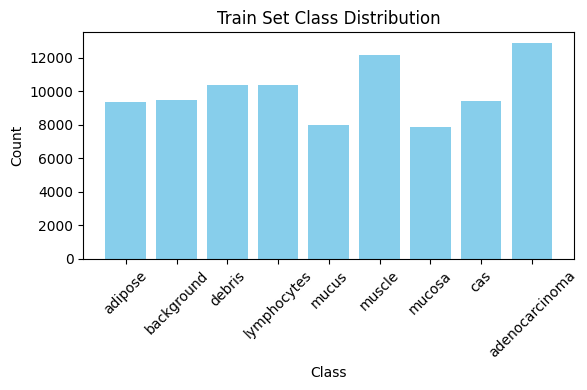


Class distribution in test set:
adipose                  : 1338 samples
background               : 847 samples
debris                   : 339 samples
lymphocytes              : 634 samples
mucus                    : 1035 samples
muscle                   : 592 samples
mucosa                   : 741 samples
cas                      : 421 samples
adenocarcinoma           : 1233 samples


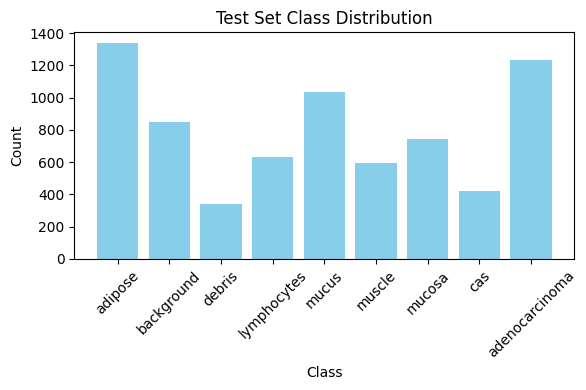


Class distribution in validation set:
adipose                  : 1041 samples
background               : 1057 samples
debris                   : 1152 samples
lymphocytes              : 1156 samples
mucus                    : 890 samples
muscle                   : 1354 samples
mucosa                   : 877 samples
cas                      : 1045 samples
adenocarcinoma           : 1432 samples


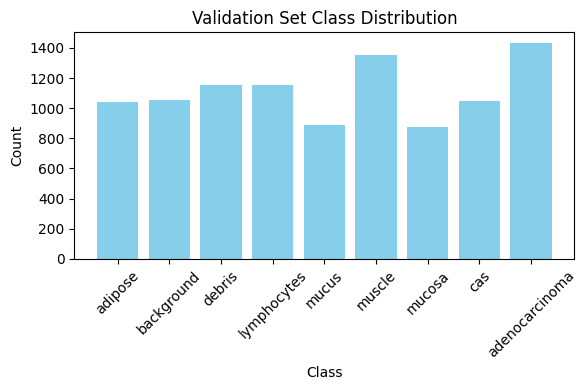

In [28]:
raw_image_metadata = pd.read_csv('/content/class_task/pathmnist_128.csv', header=None, names=['set', 'filename', 'class'])

class_names = {
    0: "adipose",
    1: "background",
    2: "debris",
    3: "lymphocytes",
    4: "mucus",
    5: "muscle", # smooth muscle
    6: "mucosa", # normal colon mucosa
    7: "cas", # cancer-associated stroma
    8: "adenocarcinoma" # colorectal adenocarcinoma epithelium
}

def compute_class_distribution(dataframe):
    return dict(Counter(dataframe['class']))

def print_distribution(dist_dict, title):
    print(f"\n{title}:")
    for class_idx in sorted(class_names):
        count = dist_dict.get(class_idx, 0)
        print(f"{class_names[class_idx]:25}: {count} samples")

def plot_distribution(dist_dict, title):
    classes = sorted(class_names.keys())
    counts = [dist_dict.get(c, 0) for c in classes]
    labels = [class_names[c] for c in classes]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

overall_dist = compute_class_distribution(raw_image_metadata)
print_distribution(overall_dist, "Class distribution in the full dataset")
plot_distribution(overall_dist, "Overall Class Distribution")

train_df = raw_image_metadata[raw_image_metadata['set'] == 'TRAIN']
train_dist = compute_class_distribution(train_df)
print_distribution(train_dist, "Class distribution in train set")
plot_distribution(train_dist, "Train Set Class Distribution")

test_df = raw_image_metadata[raw_image_metadata['set'] == 'TEST']
test_dist = compute_class_distribution(test_df)
print_distribution(test_dist, "Class distribution in test set")
plot_distribution(test_dist, "Test Set Class Distribution")

val_df = raw_image_metadata[raw_image_metadata['set'] == 'VALIDATION']
val_dist = compute_class_distribution(val_df)
print_distribution(val_dist, "Class distribution in validation set")
plot_distribution(val_dist, "Validation Set Class Distribution")

In [29]:
%cd /content/class_task
raw_image_metadata.to_csv('raw_image_metadata.csv', index=False)

/content/class_task


This next script computes the MD5 hash of every single image file in the dataset to check for duplicates. This cleanup process is not needed for the PathMNIST dataset, as it is already preprocessed and curated. However, this duplicate check could be useful for other datasets. We can see the dataset's quality and consistency in the displayed plots: all images in the dataset have the same extension, same dimensions, and same color mode distribution.

100%|██████████| 107180/107180 [02:25<00:00, 735.45it/s]



Duplicate Analysis:
Total duplicate images found: 0
No duplicates found.

File extension counts:
.png: 107180 images


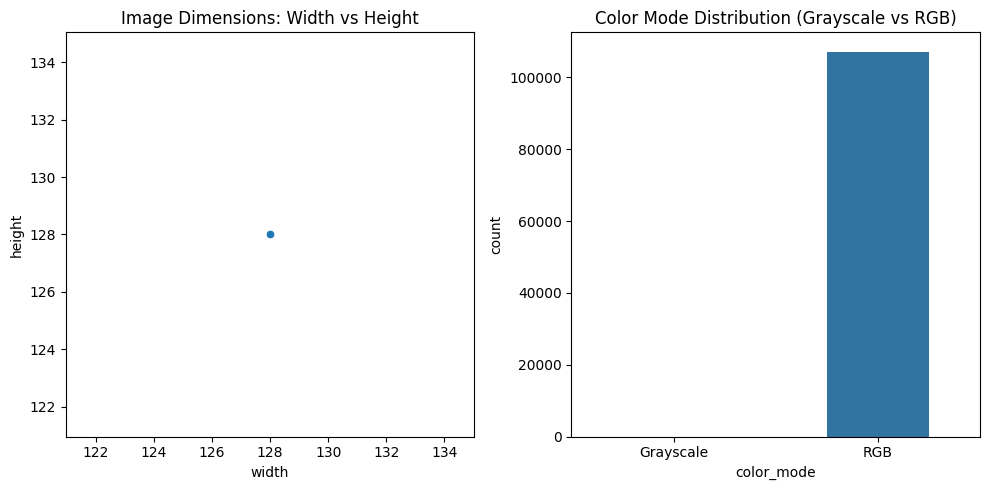

In [30]:
def get_file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def get_image_metadata_from_df(df):
    ext_count = defaultdict(int)
    unique_hashes = {}
    duplicates = []

    df['file_path'] = '/content/class_task/pathmnist_128/' + df['filename']
    df['original_extension'] = ''
    df['width'] = 0
    df['height'] = 0
    df['aspect_ratio'] = 0.0
    df['color_mode'] = ''
    df['is_duplicate'] = False
    df['original_index'] = None

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        filename = row['filename']
        img_path = row['file_path']

        img_hash = get_file_hash(img_path)

        if img_hash in unique_hashes:
            df.at[idx, 'is_duplicate'] = True
            df.at[idx, 'original_index'] = unique_hashes[img_hash]
            duplicates.append({
                'duplicate_idx': idx,
                'original_idx': unique_hashes[img_hash],
                'hash': img_hash
            })
            continue

        unique_hashes[img_hash] = idx

        width, height = imagesize.get(img_path)
        img = Image.open(img_path)
        color_mode = "RGB" if img.mode == "RGB" else "Grayscale"

        ext = os.path.splitext(filename)[1].lower()
        ext_count[ext] += 1

        df.at[idx, 'original_extension'] = ext
        df.at[idx, 'width'] = width
        df.at[idx, 'height'] = height
        df.at[idx, 'aspect_ratio'] = round(width / height, 2)
        df.at[idx, 'color_mode'] = color_mode

    duplicate_summary = {
        'total_duplicates': df['is_duplicate'].sum(),
        'detailed_duplicates': duplicates
    }

    df_clean = df[~df['is_duplicate']].copy()
    df_clean.reset_index(drop=True, inplace=True)

    return df_clean, ext_count, duplicate_summary

def display_duplicate_info(duplicate_summary):
    print("\nDuplicate Analysis:")
    print(f"Total duplicate images found: {duplicate_summary['total_duplicates']}")

    if duplicate_summary['detailed_duplicates']:
        print("\nDetailed duplicate information:")
        for dupe in duplicate_summary['detailed_duplicates']:
            print(f"  Duplicate at index {dupe['duplicate_idx']} is a copy of image at index {dupe['original_idx']}")
    else:
        print("No duplicates found.")

def display_info(img_meta_df, ext_count):
    print("\nFile extension counts:")
    for ext, count in ext_count.items():
        print(f"{ext}: {count} images")

    fig = plt.figure(figsize=(10, 5))
    gs = fig.add_gridspec(1, 2)

    # 1. Scatter plot: Width vs Height
    ax1 = fig.add_subplot(gs[0, 0])
    sns.scatterplot(x="width", y="height", data=img_meta_df, ax=ax1)
    ax1.set_title("Image Dimensions: Width vs Height")

    # 2. Histogram of Color Modes
    ax2 = fig.add_subplot(gs[0, 1])
    img_meta_df['color_mode'] = pd.Categorical(img_meta_df['color_mode'], categories=["Grayscale", "RGB"])
    sns.countplot(x="color_mode", data=img_meta_df, ax=ax2, width=0.5)
    ax2.set_title("Color Mode Distribution (Grayscale vs RGB)")

    plt.tight_layout()
    plt.show()

clean_image_metadata, ext_count, duplicate_summary = get_image_metadata_from_df(raw_image_metadata)
display_duplicate_info(duplicate_summary)
clean_image_metadata.to_csv('clean_image_metadata.csv', index=False)
display_info(clean_image_metadata, ext_count)


# 3. DATA AUGMENTATION AND FEATURE EXTRACTION

In [31]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import albumentations as A
import cv2
import random
from skimage import io, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
from skimage.filters import sobel, gabor
from skimage.color import rgb2gray
import mahotas
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import umap
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.tree import DecisionTreeClassifier

TRAINING_TARGET_SIZE = 10000
AUGMENTATION_THRESHOLD = 0.5
MAX_AUGMENTATION_FACTOR = 6
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

The dataset is already split into training, testing and validating subsets. For more clarification, see the aforementioned dataset's description and class distribution statistics.

In [32]:
clean_image_metadata['set'] = clean_image_metadata['set'].str.upper().map({
    'TRAIN': 'train',
    'TEST': 'test',
    'VALIDATION': 'val'
})

train_df = clean_image_metadata[clean_image_metadata['set'] == 'train'].copy()
val_df = clean_image_metadata[clean_image_metadata['set'] == 'val'].copy()
test_df = clean_image_metadata[clean_image_metadata['set'] == 'test'].copy()

img_updated_metadata = pd.concat([train_df, val_df, test_df], axis=0).reset_index(drop=True)

img_updated_metadata.to_csv('img_updated_metadata.csv', index=False)

Given the size of the dataset, a data ugmentation step is not really needed. As a proof of concept, I will carry out simple transformatio-based data augmentation on the less represented classes of the training set.

In [33]:
augmentation = A.Compose([
    A.SomeOf([
                            A.RandomRotate90(p=0.5),
                            A.HorizontalFlip(p=0.5),
                            A.OneOf([
                                A.GaussNoise(p=0.3),
                                A.GaussianBlur(blur_limit=(1, 3), p=0.3),
                            ], p=0.3),
                            A.Affine(scale=(0.9, 1.1),
                                     translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
                                     rotate=(-20, 20),
                                     shear={"x": 0, "y": 0}, p=0.5),
                            A.OneOf([
                                A.OpticalDistortion(p=0.2),
                                A.GridDistortion(num_steps=5, distort_limit=0.05, p=0.2),
                            ], p=0.2),
                            A.OneOf([
                                A.CLAHE(clip_limit=2, tile_grid_size=(4, 4), p=0.5),
                                A.RandomBrightnessContrast(p=0.3),
                                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
                            ], p=0.4)
        ], n=4, p=1.0)
])

In [34]:
def apply_augmentation(image_path, save_path):
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"Failed to read image: {image_path}")
            return False

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = augmentation(image=image)['image']
        augmented = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)

        cv2.imwrite(str(save_path), augmented)
        return True
    except Exception as e:
        print(f"Failed to augment image: {image_path}, Error: {e}")
        return False

In [ ]:
augmented_metadata = []

for class_name in train_df['class'].unique():
    class_df = train_df[train_df['class'] == class_name].copy()
    class_size = len(class_df)

    if class_size < TRAINING_TARGET_SIZE:
        if class_size > TRAINING_TARGET_SIZE * AUGMENTATION_THRESHOLD:
            # classes near the target size
            n_augment = TRAINING_TARGET_SIZE - class_size
            augment_indices = np.random.choice(class_size, size=n_augment, replace=False)

            tqdm_iter = tqdm(range(n_augment), desc=f'Augmenting {class_name} (near target)', leave=True)
            for i, idx in enumerate(augment_indices):
                original_row = class_df.iloc[idx]
                new_path = Path(original_row['file_path'])
                new_path = new_path.parent / f"augm_{new_path.name}"

                if apply_augmentation(original_row['file_path'], new_path):
                    augmented_metadata.append({
                        'file_path': str(new_path),
                        'class': original_row['class'],
                        'set': 'train'
                    })
                tqdm_iter.update(1)
            tqdm_iter.close()

        else:
            augmentation_factor = min(
                MAX_AUGMENTATION_FACTOR,
                int(np.ceil(TRAINING_TARGET_SIZE / class_size))
            )

            total_augmentations = len(class_df) * (augmentation_factor - 1)
            tqdm_iter = tqdm(total=total_augmentations,
                             desc=f'Augmenting {class_name} (low size) ; {augmentation_factor} times',
                             leave=True)

            for _, row in class_df.iterrows():
                for aug_idx in range(augmentation_factor - 1):
                    new_path = Path(row['file_path'])
                    new_path = new_path.parent / f"augm_{aug_idx}_{new_path.name}"

                    if apply_augmentation(row['file_path'], new_path):
                        augmented_metadata.append({
                            'file_path': str(new_path),
                            'class': row['class'],
                            'set': 'train'
                        })
                    tqdm_iter.update(1)
            tqdm_iter.close()

full_metadata = pd.concat([
    pd.DataFrame(augmented_metadata),
    train_df[['file_path', 'class', 'set']],
    val_df[['file_path', 'class', 'set']],
    test_df[['file_path', 'class', 'set']]
], ignore_index=True)

In [35]:
# TRY THE ONE BEFORE FOR OUTPUT DISPLAY ISSUE
augmented_metadata = []

for class_name in train_df['class'].unique():
    class_df = train_df[train_df['class'] == class_name].copy()
    class_size = len(class_df)

    if class_size >= TRAINING_TARGET_SIZE:
        continue

    total_augments_needed = TRAINING_TARGET_SIZE - class_size
    print(f"\nAugmenting class '{class_name}' from {class_size} to {TRAINING_TARGET_SIZE} samples")

    repeats_per_image = int(np.ceil(total_augments_needed / class_size))

    if repeats_per_image > MAX_AUGMENTATION_FACTOR:
        repeats_per_image = MAX_AUGMENTATION_FACTOR
        print(f"  [Warning] Augmentation capped to {MAX_AUGMENTATION_FACTOR}x per image")

    augments_done = 0

    for _, row in tqdm(class_df.iterrows(), desc=f"Augmenting {class_name}", total=len(class_df)):
        for aug_idx in range(repeats_per_image):
            if augments_done >= total_augments_needed:
                break

            new_path = Path(row['file_path'])
            new_path = new_path.parent / f"augm_{aug_idx}_{new_path.name}"

            if apply_augmentation(row['file_path'], new_path):
                augmented_metadata.append({
                    'file_path': str(new_path),
                    'class': row['class'],
                    'set': 'train'
                })
                augments_done += 1

        if augments_done >= total_augments_needed:
            break

full_metadata = pd.concat([
    pd.DataFrame(augmented_metadata),
    train_df[['file_path', 'class', 'set']],
    val_df[['file_path', 'class', 'set']],
    test_df[['file_path', 'class', 'set']]
], ignore_index=True)


Augmenting class '0' from 9366 to 10000 samples


Augmenting 0:   7%|▋         | 633/9366 [00:03<00:54, 159.44it/s]



Augmenting class '4' from 8006 to 10000 samples


Augmenting 4:  25%|██▍       | 1993/8006 [00:10<00:30, 196.29it/s]



Augmenting class '7' from 9401 to 10000 samples


Augmenting 7:   6%|▋         | 598/9401 [00:04<00:59, 146.97it/s]



Augmenting class '1' from 9509 to 10000 samples


Augmenting 1:   5%|▌         | 490/9509 [00:02<00:50, 177.39it/s]



Augmenting class '6' from 7886 to 10000 samples


Augmenting 6:  27%|██▋       | 2113/7886 [00:10<00:27, 208.62it/s]


In [36]:
for split in ['train', 'val', 'test']:
    print(f"\n{split.capitalize()} set:")
    split_counts = full_metadata[full_metadata['set'] == split]['class'].value_counts()
    print(split_counts)
    print(f"  Total: {split_counts.sum()}")


Train set:
class
8    12885
5    12182
3    10401
2    10360
0    10000
6    10000
1    10000
7    10000
4    10000
Name: count, dtype: int64
  Total: 95828

Val set:
class
8    1432
5    1354
3    1156
2    1152
1    1057
7    1045
0    1041
4     890
6     877
Name: count, dtype: int64
  Total: 10004

Test set:
class
0    1338
8    1233
4    1035
1     847
6     741
3     634
5     592
7     421
2     339
Name: count, dtype: int64
  Total: 7180
